In [13]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel, AutoImageProcessor, AutoModel

import hydra
from hydra import compose, initialize
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

import pyrootutils

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision.transforms import functional as TF

from probes import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def setup(model='base_vlm', task='base_vlm_task'):
    '''
    Annoying but necessary function to setup the hydra environment within a jupyter notebook.
    '''
    pyrootutils.setup_root('.', dotenv=True, pythonpath=True)
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(config_path='config')
    cfg = compose(config_name='run', overrides=[f'model={model}', f'task={task}'])
    return cfg

class ImageDataset(Dataset):
    def __init__(self, xs, df, target_feature):
        ys = torch.tensor(df[target_feature].values.astype(int)-1)
        self.ys = F.one_hot(ys, ys.max()+1).to(dtype=torch.float32)
        self.xs = xs
    def __len__(self):
        return len(self.xs)
    def __getitem__(self, i):
        return self.xs[i], self.ys[i]

#### Let's start with CLIP!

In [16]:
def compute_embeddings(model, processor, dataloader, device):
    embeddings, targets = [], []
    model.eval()
    with torch.no_grad():
        for xs, ys in tqdm(dataloader, desc='Computing embeddings'):
            xs = xs.to(device)
            inputs = processor(images=xs, return_tensors='pt', do_rescale=False).to(device)
            img_emb = model.get_image_features(**inputs)
            embeddings.append(img_emb)
            targets.append(ys)
    return torch.cat(embeddings), torch.cat(targets)

def train_probe(probe, train_loader, val_loader, n_epochs, device, log_interval=50):
    probe.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(probe.parameters(), lr=5e-4)
    train_accs, val_accs = [], []
    
    for epoch in range(n_epochs):
        probe.train()
        train_loss, train_acc = 0, 0
        for xs, ys in train_loader:
            xs, ys = xs.to(device), ys.to(device)
            optimizer.zero_grad()
            outputs = probe(xs)
            loss = criterion(outputs, ys)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (outputs.argmax(1) == ys.argmax(1)).float().mean().item()
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        
        val_acc = evaluate_probe(probe, val_loader, device)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        if epoch % log_interval == 0:
            print(f'Epoch {epoch}/{n_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    return probe, train_accs, val_accs

def evaluate_probe(probe, dataloader, device):
    probe.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xs, ys in dataloader:
            xs, ys = xs.to(device), ys.to(device)
            outputs = probe(xs)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_targets.extend(ys.argmax(1).cpu().numpy())
    return accuracy_score(all_targets, all_preds)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load CLIP model and processor
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32').to(device)
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

# Load your dataset (replace this with your actual dataset loading code)
batch_size = 256
cfg = setup(task='counting')
task = instantiate(cfg.task)
dataset = ImageDataset(task.dataset_tensor, task.results_df, 'n_objects')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Compute embeddings
embeddings, targets = compute_embeddings(model, processor, dataloader, device)

# Create a new dataset with embeddings and targets
full_dataset = TensorDataset(embeddings, targets)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize and train the probe
input_dim = embeddings.shape[1]
hidden_dim = input_dim
output_dim = len(torch.unique(targets.argmax(1)))
probe = CampbellMLP(input_dim, hidden_dim, output_dim)
trained_probe, train_accs, val_accs = train_probe(probe, train_loader, val_loader, n_epochs=1000, device=device)

# Evaluate on test set
test_acc = evaluate_probe(trained_probe, test_loader, device)
print(f'Test Accuracy: {test_acc:.4f}')

Using device: cuda
Loading task metadata from /scratch/gpfs/ic0523/ACSS-2024/data/counting/metadata.csv...


Computing embeddings: 100%|██████████| 20/20 [07:21<00:00, 22.07s/it]


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

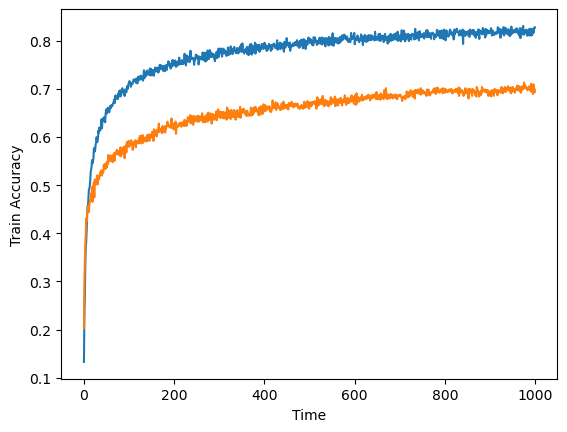

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [55]:
# Plot performance over time.
performance_df = pd.DataFrame({'Train Accuracy': np.array(train_accs), 'Val Accuracy': np.array(val_accs)})
performance_df['Time'] = np.arange(len(val_accs))
sns.lineplot(data=performance_df, x='Time', y='Train Accuracy')
sns.lineplot(data=performance_df, x='Time', y='Val Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Time')
plt.legend()
plt.show()

# Plot the similarity structure of the embeddings.
n_objects = ys.argmax(1)
sort_idx = n_objects.argsort()
xs_sorted = xs[sort_idx].cpu().numpy()
n_objects = n_objects[sort_idx]
sim_mat = cosine_similarity(xs, xs)
plt.imshow(sim_mat)

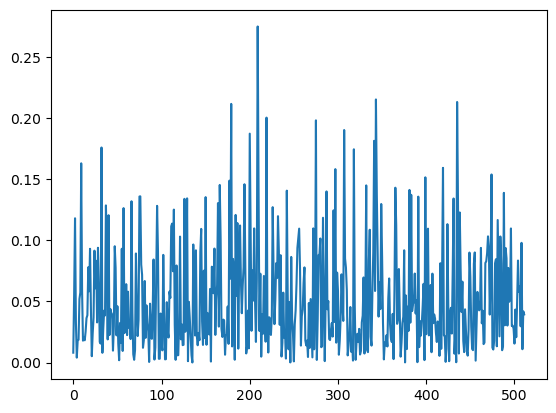

In [75]:
weights = np.abs(probe.classifier[2].weight.data[:].mean(0).cpu())
plt.plot(weights)

#### Probing for DINOv2 (without pooling).

In [17]:
# Load the environment and the dataset.
batch_size = 1
cfg = setup()
task = instantiate(cfg.task)
dataset = ImageDataset(task.results_df, 'n_objects')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load the model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

# First compute the image embeddings and inspect their shape.
print('Computing embeddings...')
targets = []
embs = []
for (xs, ys) in tqdm(dataloader):
    with torch.no_grad():
        inputs = processor(images=xs.to(device), return_tensors='pt', do_rescale=False)
        img_emb = model.get_image_features(**inputs)
        embs.append(img_emb)
        targets.append(ys)
xs = torch.cat(embs).mean(1)
ys = torch.cat(targets)
print(f'    Embeddings shape: {xs.shape}')

# Now only train an MLP to predict the number of objects from the CLIP embedding.
print('Fitting probe...')
probe = CampbellMLP(xs.shape[-1], xs.shape[-1], ys.shape[-1], dropout_prob=0.2, single_span=True)
optimizer = Adam(probe.parameters(), lr=5e-4)
probe, _, accuracies = fit_probe(probe, xs, ys, n_epochs=1000, pool=True, log_interval=50)

Loading task metadata from /Users/ic0523/Documents/projects/misc/ACSS-2024/data/counting/metadata.csv...
Computing embeddings...


100%|██████████| 5000/5000 [03:54<00:00, 21.36it/s]


    Embeddings shape: torch.Size([5000])
Fitting probe...


ValueError: too many values to unpack (expected 2)

In [ ]:
# Plot performance over time.
performance_df = pd.DataFrame({'Accuracy': accuracies})
performance_df['Time'] = np.arange(len(accuracies))
performance_df['Accuracy'] = pd.rolling_mean(performance_df['Accuracy'], window=100) # Smooth
sns.lineplot(data=performance_df, x='Time', y='Accuracy')

# Plot the similarity structure of the embeddings.
n_objects = ys.argmax(1)
sort_idx = n_objects.argsort()
xs_sorted = xs[sort_idx].cpu().numpy()
n_objects = n_objects[sort_idx]
sim_mat = cosine_similarity(xs, xs)
plt.imshow(sim_mat)

#### Probing for DINOv2 (with pooling).

In [ ]:
class Probe(torch.nn.Module):
    def __init__(self, pooler, probe_mlp):
        super().__init__()
        self.pooler = pooler
        self.probe = probe_mlp
    def forward(self, x):
        xs = self.pooler(x)
        ys = self.probe(xs)
        return xs, ys

# Load the environment and the dataset.
batch_size = 1
cfg = setup()
task = instantiate(cfg.task)
dataset = ImageDataset(task.results_df, 'n_objects')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load the model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

# First compute the image embeddings and inspect their shape.
print('Computing embeddings...')
targets = []
embs = []
for (xs, ys) in tqdm(dataloader):
    with torch.no_grad():
        inputs = processor(images=xs.to(device), return_tensors='pt', do_rescale=False)
        img_emb = model.get_image_features(**inputs)
        embs.append(img_emb)
        targets.append(ys)
xs = torch.cat(embs)
ys = torch.cat(targets)
print(f'    Embeddings shape: {embs.shape}')

# Now only train an MLP to predict the number of objects from the CLIP embedding.
print('Fitting probe...')
pooler = AttentionPooler(xs.shape[-1], xs.shape[-1])
mlp = CampbellMLP(xs.shape[-1], xs.shape[-1], ys.shape[-1], dropout_prob=0.2, single_span=True)
probe = Probe(pooler, mlp)
optimizer = Adam(probe.parameters(), lr=5e-4)
probe, _, accuracies = fit_probe(probe, xs, ys, n_epochs=100, pool=True, log_interval=5)

In [ ]:
# Plot performance over time.
performance_df = pd.DataFrame({'Accuracy': accuracies})
performance_df['Time'] = np.arange(len(accuracies))
performance_df['Accuracy'] = pd.rolling_mean(performance_df['Accuracy'], window=100) # Smooth
sns.lineplot(data=performance_df, x='Time', y='Accuracy')

# Plot the similarity structure of the embeddings.
n_objects = ys.argmax(1)
sort_idx = n_objects.argsort()
xs_sorted = xs[sort_idx].cpu().numpy()
n_objects = n_objects[sort_idx]
sim_mat = cosine_similarity(xs, xs)
plt.imshow(sim_mat)

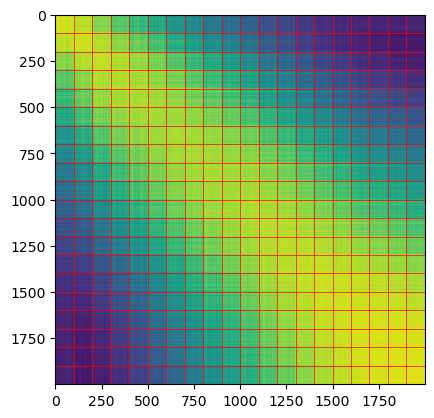

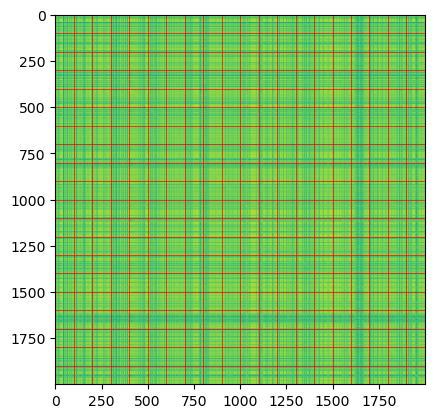

In [40]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Plot the similarity structure of the embeddings.
pooled_xs = pooled[-1].detach().numpy()
n_objects = ys.argmax(1)
sort_idx = n_objects.argsort()
xs_sorted = pooled_xs[sort_idx]
n_objects = n_objects[sort_idx]
sim_mat = cosine_similarity(xs_sorted, xs_sorted)
plt.imshow(sim_mat)
plt.axis('off')
# Draw lines to separate the different classes.
for i in range(1, n_objects.max()+1):
    plt.axvline(i*100, color='r', linewidth=0.5)
    plt.axhline(i*100, color='r', linewidth=0.5)
plt.show()

# Plot the similarity structure of the embeddings.
sort_idx = n_objects.argsort()
xs_sorted = xs[sort_idx].mean(1).detach().numpy()
n_objects = n_objects[sort_idx]
new_sim_mat = cosine_similarity(xs_sorted, xs_sorted)
plt.imshow(new_sim_mat)
plt.axis('off')
# Draw lines to separate the different classes.
for i in range(1, n_objects.max()+1):
    plt.axvline(i*100, color='r', linewidth=0.5)
    plt.axhline(i*100, color='r', linewidth=0.5)

#### Plot how similar each n_objects is with other n_objects (increased similarity with more objects?)

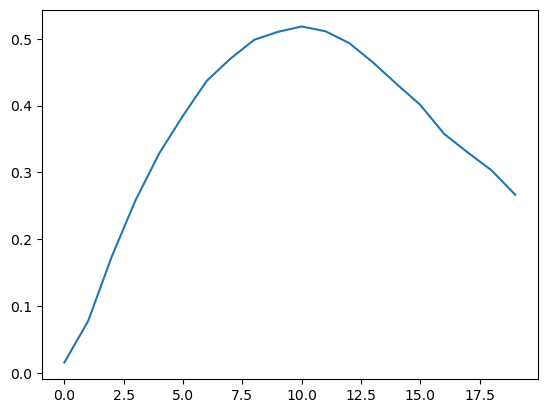

In [46]:
plt.plot(sim_mat.reshape(20, 100, 2000).mean((1,2)))

#### Now DINOv2

In [ ]:
# Load the environment and the dataset.
batch_size = 1
cfg = setup()
task = instantiate(cfg.task)
dataset = ImageDataset(task.results_df, 'n_objects')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load the model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')

In [ ]:
targets = []
embs = []
for (xs, ys) in tqdm(dataloader):
    with torch.no_grad():
        inputs = processor(images=xs.to(device), return_tensors='pt', do_rescale=False)
        img_emb = model(**inputs).last_hidden_state
        embs.append(img_emb)
        targets.append(ys)

### Project ideas:
##### 1. Are shapes or colors more easily decodable from VLMs? (the result may surprise you!)
##### 2. Signatures of compositional feature representations in CLIP? (i.e. replicate and extend [Lewis et al 2022](https://arxiv.org/abs/2212.10537) using TPR probes).
##### 3. 